This notebook does 2 things:

1. Applies different resenet architectures and selects the
   model and architecture based on the validation loss.

1. Calculates AUC ROC score fo the best model.

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from fastai2.metrics import RocAuc
from fastai2.vision.all import *

from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
y_train, y_test = train_test_split(df.target, random_state=42, 
                                   test_size=0.33)

train_pos_indexes = y_train[y_train==1].index

train_neg_indexes = np.random.choice(y_train[y_train==0].index,3840)

df['purpose'] = np.nan

df.loc[y_test.index.tolist() ,'purpose'] = 'val'
df.loc[train_pos_indexes, 'purpose' ] = 'train'
df.loc[train_neg_indexes, 'purpose' ] = 'train'

def custom_splitter(df):
    train = df.index[df.purpose=='train'].tolist()
    val   = df.index[df.purpose=='val'].tolist()

    return train, val

In [6]:
dblock = DataBlock((ImageBlock, CategoryBlock),
                   splitter = custom_splitter,
                   get_x = lambda r: f"data/jpeg/train-224/{r['image_name']}.jpg",
                   get_y = lambda r : str(r["target"]),
                   item_tfms = None)


dls = dblock.dataloaders(df,bs=32, num_workers = 0)


In [7]:
learn = cnn_learner(dls, resnet18,metrics = [accuracy, RocAuc()],
                   loss=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0002290867705596611)

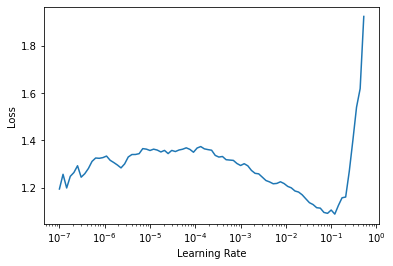

In [76]:
learn.lr_find()

In [8]:
learn.fit_one_cycle(3, lr=3e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.834969,0.284222,0.900201,0.662122,00:51
1,0.451294,0.179586,0.936791,0.668490,00:49
2,0.312302,0.154898,0.948225,0.647327,00:49


SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=6.309573450380412e-07)

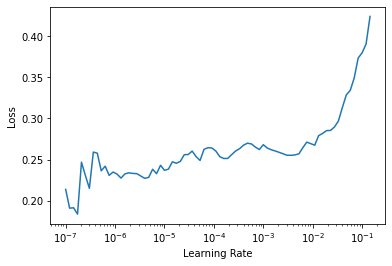

In [10]:
learn.lr_find()

In [11]:
learn.unfreeze()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=1.5848931980144698e-06)

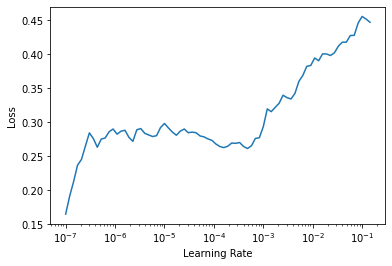

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(5,slice(3e-5,3e-4))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.307950,0.174341,0.936242,0.675571,00:53
1,0.265994,0.175073,0.931120,0.660695,00:53
2,0.175970,0.147234,0.945756,0.650976,00:53
3,0.096407,0.146009,0.950695,0.668212,00:53
4,0.063450,0.125033,0.958562,0.640324,00:53


In [15]:
learn.fit_one_cycle(10,slice(3e-5,3e-4))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.051953,0.150949,0.947402,0.678802,00:53
1,0.069124,0.144181,0.958562,0.645231,00:53
2,0.093182,0.124662,0.964508,0.631086,00:53
3,0.106401,0.145926,0.954903,0.613927,00:53
4,0.069627,0.116410,0.968350,0.576614,00:53
5,0.048484,0.131663,0.965331,0.641318,00:53
6,0.022497,0.151166,0.956824,0.644346,00:53
7,0.013498,0.141136,0.963319,0.650107,00:54
8,0.010609,0.118646,0.970454,0.602220,00:56
9,0.008569,0.127282,0.967344,0.627623,00:53
